In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
article = pd.read_csv('../data/article_info.csv')
view_log = pd.read_csv('../data/view_log.csv')

# Article Info

<Axes: xlabel='Language', ylabel='count'>

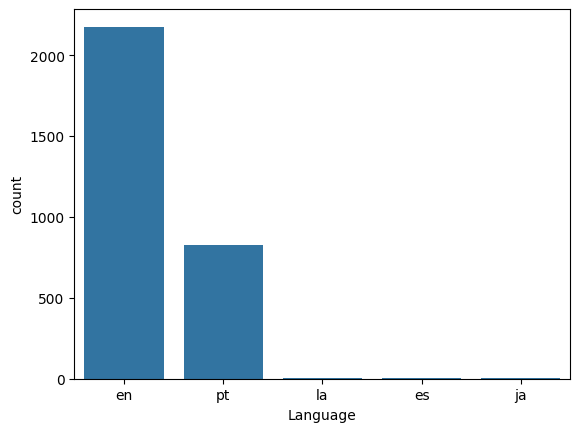

In [3]:
sns.barplot(article['Language'].value_counts())

<Axes: xlabel='Format', ylabel='count'>

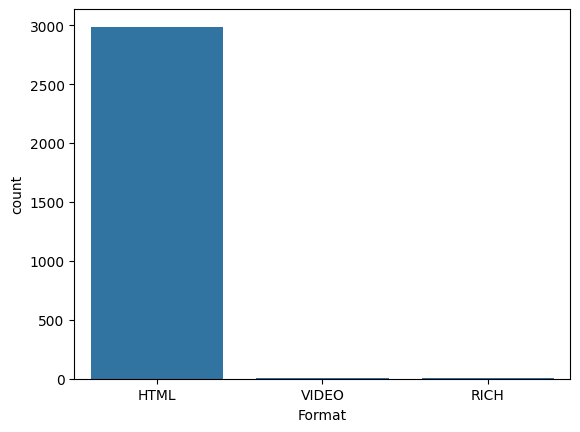

In [4]:
sns.barplot(article['Format'].value_counts())

In [5]:
pt_article = article[article['Language'] == 'pt']
la_article = article[article['Language'] == 'la']
es_article = article[article['Language'] == 'es']
jp_article = article[article['Language'] == 'ja']

In [6]:
es_article.sample().T

,988
articleID,ARTICLE_0988
Title,La RAE lucha contra los anglicismos con una ca...
Content,La Real Academia Española alerta sobre su abus...
Format,HTML
Language,es
userID,USER_1166
userCountry,NaN
userRegion,NaN


<Axes: xlabel='title_len', ylabel='Count'>

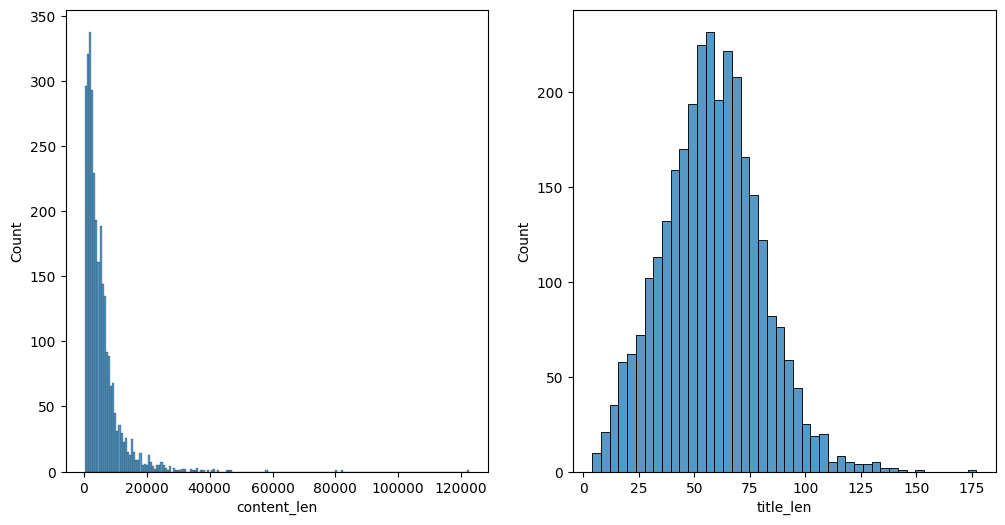

In [7]:
article['content_len'] = article['Content'].apply(len)
article['title_len'] = article['Title'].apply(len)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(article['content_len'], ax=axes[0])
sns.histplot(article['title_len'], ax=axes[1])

In [8]:
view_log_cnt = pd.DataFrame(view_log.groupby(by='articleID')['userID'].count()).reset_index()
view_log_cnt.columns = ['articleID', 'count']

In [9]:
article_meta = view_log_cnt.merge(article[['articleID', 'Format', 'Language', 'content_len', 'title_len']], on='articleID')

In [10]:
article_meta.head()

,articleID,count,Format,Language,content_len,title_len
0,ARTICLE_0000,21,HTML,en,19831,28
1,ARTICLE_0001,12,HTML,en,2165,84
2,ARTICLE_0002,6,HTML,en,15743,44
3,ARTICLE_0003,3,HTML,en,8861,77
4,ARTICLE_0004,10,HTML,en,4065,64


<Axes: >

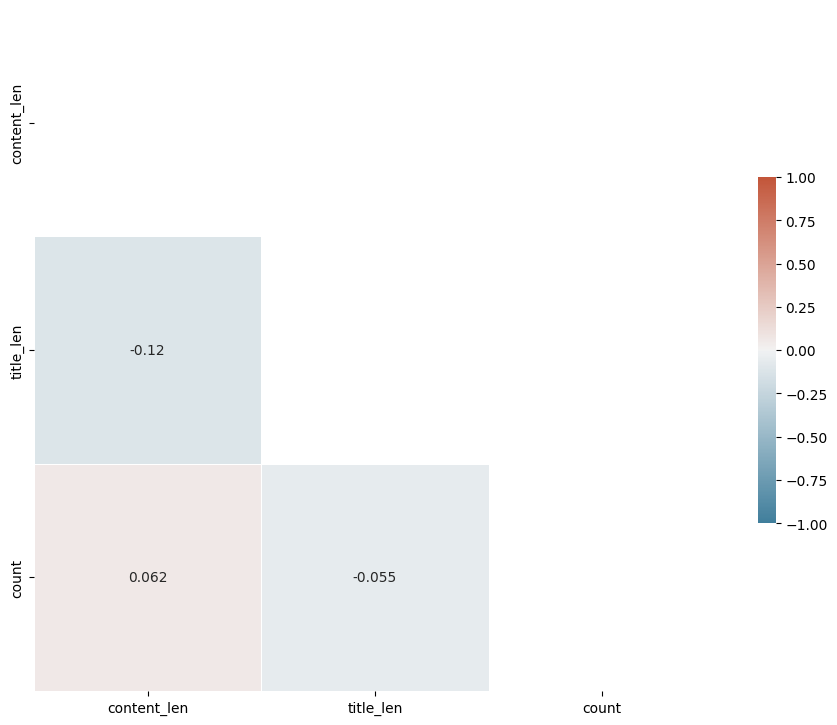

In [11]:
corr = article_meta[['content_len', 'title_len', 'count']].corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# View_log

In [12]:
lang_cnt = pd.DataFrame(article_meta['Language'].value_counts()).reset_index()
lang_cnt.columns = ['Language', 'count']

In [13]:
lang_view = pd.DataFrame(article_meta.groupby(by='Language')['count'].sum()).reset_index()
lang_view.columns = ['Language', 'view_sum']

In [14]:
lang_info = lang_view.merge(lang_cnt, on='Language')

In [15]:
lang_info['avg_view_per_lang'] = round(lang_info['view_sum'] / lang_info['count'],3)

In [16]:
user_per_article = view_log.groupby(by='articleID')['userID'].unique().reset_index()
user_per_article.columns = ['articleID', 'viewed_users']

In [17]:
view_log.userCountry.unique()

array(['US', 'BR', 'JP', 'KR', 'CN', 'DE', 'PT', 'CO', 'AU', 'MY', 'SG',
       'CA', 'IE', 'IT', 'AR', 'CL', 'NL', 'GB', 'CH', 'ES', 'IS'],
      dtype=object)

In [18]:
import duckdb
# MEMORY 내에서만 활용
conn = duckdb.connect()

In [19]:
view_log_meta = conn.sql(f"""
with author as (
select 
    distinct(userID)
from
    article)

select
    *,
    case
        when userID in (select * from author) then 1
        else 0
    end as is_author
from
    view_log
""").df()

In [20]:
view_log_meta

,userID,articleID,userRegion,userCountry,is_author
0,USER_0000,ARTICLE_0661,NY,US,1
1,USER_0000,ARTICLE_2316,NY,US,1
2,USER_0000,ARTICLE_1345,NY,US,1
3,USER_0000,ARTICLE_1089,NY,US,1
4,USER_0000,ARTICLE_1484,NY,US,1
...,...,...,...,...,...
42712,USER_1420,ARTICLE_0682,SP,BR,1
42713,USER_1420,ARTICLE_2179,SP,BR,1
42714,USER_1420,ARTICLE_1848,SP,BR,1
42715,USER_1420,ARTICLE_0030,SP,BR,1


In [21]:
total_author = article['userID'].nunique()

In [22]:
total_author

251

In [23]:
author_per_article = view_log_meta.groupby(by='articleID')['is_author'].sum() / total_author * 100

In [24]:
author_per_article = author_per_article.reset_index()
author_per_article.columns = ['articleID', 'percentage']

<Axes: ylabel='percentage'>

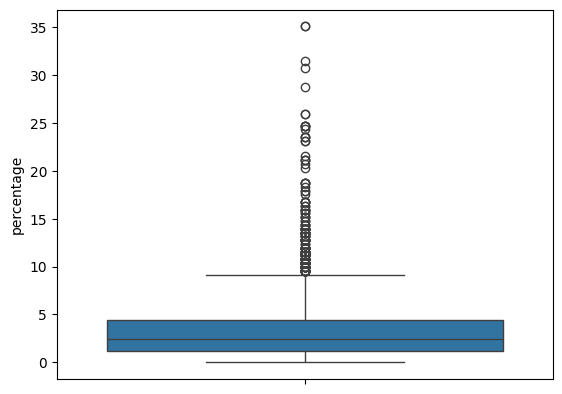

In [25]:
sns.boxplot(author_per_article['percentage'])

In [26]:
article_meta = article_meta.merge(author_per_article, on='articleID')

<Axes: >

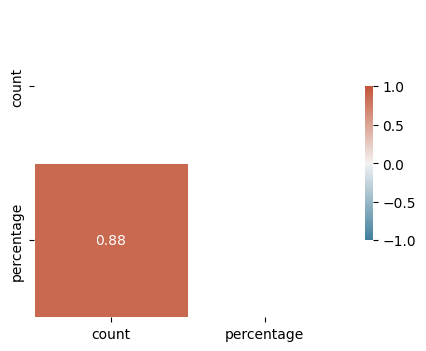

In [27]:
corr = article_meta[['count', 'percentage']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [28]:
view_log_meta

,userID,articleID,userRegion,userCountry,is_author
0,USER_0000,ARTICLE_0661,NY,US,1
1,USER_0000,ARTICLE_2316,NY,US,1
2,USER_0000,ARTICLE_1345,NY,US,1
3,USER_0000,ARTICLE_1089,NY,US,1
4,USER_0000,ARTICLE_1484,NY,US,1
...,...,...,...,...,...
42712,USER_1420,ARTICLE_0682,SP,BR,1
42713,USER_1420,ARTICLE_2179,SP,BR,1
42714,USER_1420,ARTICLE_1848,SP,BR,1
42715,USER_1420,ARTICLE_0030,SP,BR,1


In [29]:
country_counts = view_log_meta.groupby(['articleID', 'userCountry']).size().reset_index(name='count')

In [30]:
country_counts

,articleID,userCountry,count
0,ARTICLE_0000,BR,21
1,ARTICLE_0001,BR,8
2,ARTICLE_0001,US,4
3,ARTICLE_0002,BR,6
4,ARTICLE_0003,BR,1
...,...,...,...
4632,ARTICLE_3005,US,1
4633,ARTICLE_3006,BR,56
4634,ARTICLE_3006,US,2
4635,ARTICLE_3007,BR,8


In [31]:
grouped = country_counts.groupby(['articleID', 'userCountry'])['count'].sum().reset_index()

# Step 2: Pivot the table to get countries as columns
pivoted = grouped.pivot(index='articleID', columns='userCountry', values='count').fillna(0)

# Step 3: Calculate the total views per article
pivoted['total_views'] = pivoted.sum(axis=1)

# Step 4: Calculate the percentage of views from Brazil
pivoted['BR_percentage'] = round((pivoted.get('BR', 0) / pivoted['total_views']) * 100, 3)

# Step 5: Display results
result = pivoted[['total_views', 'BR_percentage']].reset_index()
result.columns = ['articleID', 'total_view', 'BR_per']

In [32]:
grouped = country_counts.groupby(['articleID', 'userCountry'])['count'].sum().reset_index()

# Step 2: Pivot the table to get countries as columns
pivoted = grouped.pivot(index='articleID', columns='userCountry', values='count').fillna(0)

# Step 3: Calculate the total views per article
pivoted['total_views'] = pivoted.sum(axis=1)

# Step 4: Calculate the percentage of views from Brazil
pivoted['US_percentage'] = round((pivoted.get('US', 0) / pivoted['total_views']) * 100, 3)

# Step 5: Display results
us_result = pivoted[['total_views', 'US_percentage']].reset_index()
us_result.columns = ['articleID', 'total_view', 'US_per']

<Axes: xlabel='US_per', ylabel='Count'>

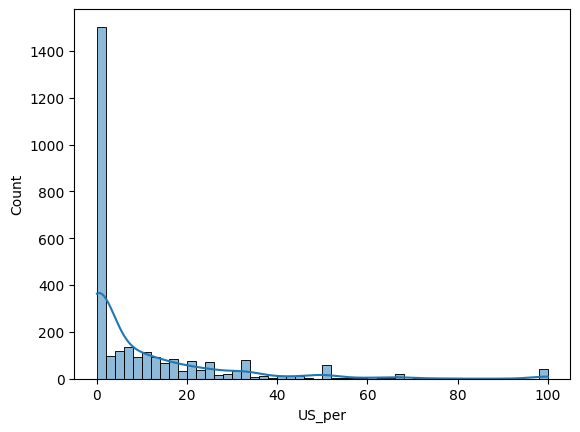

In [33]:
sns.histplot(us_result['US_per'], kde=True)

<Axes: xlabel='BR_per', ylabel='Count'>

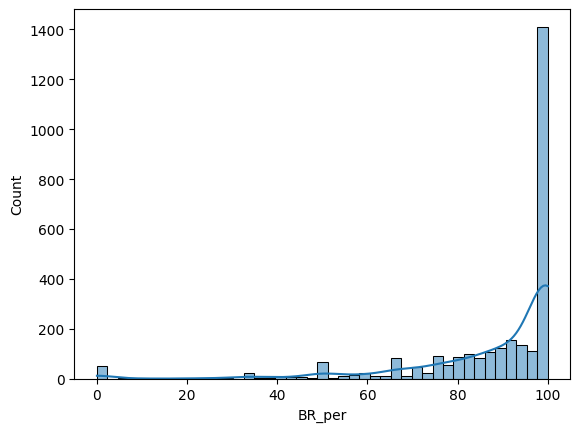

In [34]:
sns.histplot(result['BR_per'], kde=True)

<Axes: xlabel='userCountry', ylabel='count'>

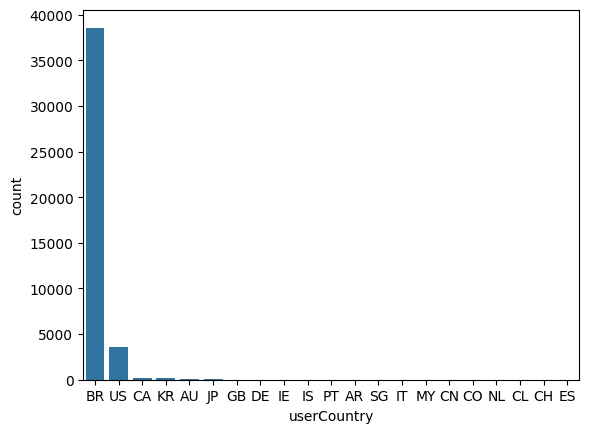

In [42]:
sns.barplot(view_log['userCountry'].value_counts())

In [40]:
view_log.describe()

,userID,articleID,userRegion,userCountry
count,42717,42717,42717,42717
unique,1415,2879,56,21
top,USER_0222,ARTICLE_2868,SP,BR
freq,974,291,30127,38566
